# 1.0 Imports e Leitura dos Dados

Nesta seção eu concentro todos as importações de bibliotecas, leitura de dados e funções auxiliares que serão utilizadas repetidas vezes no restante do código. O objetivo dela é organização.

In [201]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from sqlalchemy import create_engine

# Carregando Variáveis de Ambiente
load_dotenv()

True

In [202]:
DB_USER = os.getenv("DB_USER")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_DATABASE = os.getenv("DB_DATABASE")

engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_DATABASE}")

## 1.1 Leitura dos Dados

In [203]:
# Gosto de usar o gerenciador de recursos ( with ) para interação com bancos de dados via código por simplificar o uso das conexões - ele executa um .close() automático, à título de exemplo.
with engine.connect() as connection:
    df_daumau = pd.read_sql(
        sql = "SELECT * FROM case_data_scientist.daumau",
        con = connection
    )
    df_desinstalacoes = pd.read_sql(
        sql = "SELECT * FROM case_data_scientist.desinstalacoes",
        con = connection
    )
    df_instalacoes = pd.read_sql(
        sql = "SELECT * FROM case_data_scientist.installs",
        con = connection
    )
    df_reviews = pd.read_sql(
        sql = "SELECT * FROM case_data_scientist.ratings_reviews",
        con = connection
    )

## 1.2 Funções Auxiliares

In [204]:
# Função cujo output é um report completo das linhas duplicadas no DataFrame, inclusive analisando coluna por coluna
def duplicated_report(df: pd.DataFrame):
    numero_duplicados_dataframe_inteiro = df.duplicated().sum()

    if numero_duplicados_dataframe_inteiro > 0:
        print(f'O DataFrame inteiro apresenta {numero_duplicados_dataframe_inteiro} registros completamente duplicados (linhas repetidas)!')
    else:
        print('O DataFrame inteiro não apresenta nenhum registro duplicado.')
        
    print('\n')

    for col in df.columns:
        numero_duplicados_coluna = df[col].duplicated().sum()

        if numero_duplicados_coluna > 0:
            print(f'A coluna {col} apresenta {numero_duplicados_coluna} registros duplicados!')
            print('\n')

# Função para gerar as estatísticas descritivas de colunas numéricas com formato legível
def estatistica_descritiva(df: pd.DataFrame, column: str):
    summary = df[column].describe().apply(lambda x: f"{x:,.2f}")
    print(summary)

# 2.0 Entendimento dos Dados

Nessa etapa busco uma visão geral do dataset que será utilizado. Os objetivos são entender os formatos de cada tabela, quantidade de linhas, de colunas, tipagem dos dados, dados nulos e duplicados.

## 2.1 DataFrame DAUMAU (Daily Active Users & Monthly Active Users)

**Visualização rápida das primeiras linhas da base.**

Aqui busco entender como o dataset se parece e que tipos de informação podemos encontrar dentro dele.

Já entendo parte da base:

- **dauReal** (daily active users real): quantidade de usuários ativos no dia
- **mauReal** (monthly active users real): quantidade de usuários ativos no mês
- **date**: data referente a este registro de usuários ativos
- **appId**: provavelmente a chave primária das 4 tabelas

In [205]:
df_daumau.head()

,appId,date,dauReal,mauReal
0,com.app.33540,2024-01-01,393961.0,3643110.0
1,com.app.33540,2024-01-02,800448.0,3643040.0
2,com.app.31679,2024-01-01,157532.0,1349262.0
3,com.app.31679,2024-01-02,313847.0,1349317.0
4,com.app.77385,2024-01-01,239768.0,1934660.0


**Checar tipos de dados.**

Meu principal objetivo nessa parte é entender se a tipagem das colunas está correta para dar continuidade na Análise Exploratória.

Nesse caso, pude verificar que a coluna **date** não estava como date, o que não me permitiria fazer algum tipo de ordenação e checar máximos e mínimos na análise posterior, por isso a correção foi feita.

In [206]:
df_daumau.dtypes

appId       object
date        object
dauReal    float64
mauReal    float64
dtype: object

In [207]:
df_daumau["date"] = pd.to_datetime(df_daumau["date"])

**Checar tamanho da base (linhas x colunas)**

Entendo qual é a dimensão dos dados que estou trabalhando.

In [208]:
df_daumau.shape

(41299, 4)

**Checar possíveis dados duplicados**

Nesta parte, a única coisa anormal me parece ser os 153 registros totalmente duplicados (appId, date, dauReal e mauReal), para resolver isso faço um .drop_duplicates().

As colunas isoladamente fazem sentido terem valores duplicados.

In [209]:
duplicated_report(df_daumau)

O DataFrame inteiro apresenta 153 registros completamente duplicados (linhas repetidas)!


A coluna appId apresenta 41103 registros duplicados!


A coluna date apresenta 40951 registros duplicados!


A coluna dauReal apresenta 9260 registros duplicados!


A coluna mauReal apresenta 2717 registros duplicados!




In [210]:
df_daumau = df_daumau.drop_duplicates()

**Checar dados nulos**

Alguns valores nulos apareceram no DataFrame, e adotei algumas premissas para tratá-los.

- **appId**: é a chave primária e não conseguimos juntar linhas com o id nulo com nenhuma outra tabela, e como são poucos registros, decidi eliminá-los.
- **dauReal**: substitui por 0 os valores nulos em Daily Active Users que tem Monthly Active Users preenchidos, presumindo que simplesmente não teve nenhum acesso no app naquela data.
- **mauReal**: eliminei as linhas com Monthly Active Users nulos pois parece que todas pertecen a um só appId (com.app.90128) e todos os registros pra esse app estão com essas linhas nulas.

In [211]:
df_daumau.isna().sum()

appId       28
date         0
dauReal    194
mauReal     20
dtype: int64

In [212]:
df_daumau = df_daumau.dropna(subset=['appId','mauReal'], how='any')

df_daumau['dauReal'] = df_daumau['dauReal'].fillna(0)

## 2.2 DataFrame Desinstalações

**Visualização rápida das primeiras linhas da base.**


- **country** país do app
- **lang** linguagem do país do app
- **predictionLoss**:

In [213]:
df_desinstalacoes.head()

,appId,date,country,lang,predictionLoss
0,com.app.71740,2024-01-01,br,pt,1463
1,com.app.33540,2024-01-01,br,pt,8170
2,com.app.19544,2024-01-01,br,pt,77048
3,com.app.77385,2024-01-01,br,pt,4497
4,com.app.31679,2024-01-01,br,pt,4287


**Checar tipos de dados.**

Tudo certo aqui.

In [214]:
df_desinstalacoes.dtypes

appId                     object
date              datetime64[ns]
country                   object
lang                      object
predictionLoss             int64
dtype: object

**Checar tamanho da base (linhas x colunas)**

In [215]:
df_desinstalacoes.shape

(53188, 5)

**Checar possíveis dados duplicados**

Nada anormal, nenhum registro inteiro duplicados, e todas as colunas isoladamente fazem sentido terem valores duplicados.

In [216]:
duplicated_report(df_desinstalacoes)

O DataFrame inteiro não apresenta nenhum registro duplicado.


A coluna appId apresenta 52993 registros duplicados!


A coluna date apresenta 52907 registros duplicados!


A coluna country apresenta 53187 registros duplicados!


A coluna lang apresenta 53187 registros duplicados!


A coluna predictionLoss apresenta 34777 registros duplicados!




**Checar dados nulos**

In [217]:
df_desinstalacoes.isna().sum()

appId             0
date              0
country           0
lang              0
predictionLoss    0
dtype: int64

## 2.3 DataFrame Instalações

**Visualização rápida das primeiras linhas da base.**

- **newinstalls** (Novas Intalações): número de usuários que instalaram o app naquela data.

In [218]:
df_instalacoes.head()

,appid,date,newinstalls
0,com.app.86367,2024-01-01,1968
1,com.app.18711,2024-01-01,1364
2,com.app.36257,2024-01-01,7511
3,com.app.88509,2024-01-01,53137
4,com.app.93131,2024-01-01,137


**Checar tipos de dados.**

Tudo certo aqui.

In [219]:
df_instalacoes.dtypes

appid                  object
date           datetime64[ns]
newinstalls             int64
dtype: object

**Checar tamanho da base (linhas x colunas)**

In [220]:
df_instalacoes.shape

(48150, 3)

**Checar possíveis dados duplicados**

Semelhante ao DataFrame DAUMAU, o único estranho aqui são os 171 registros competamente duplicados, e para resolvê-los realizei um .drop_duplicates()

In [221]:
duplicated_report(df_instalacoes)

O DataFrame inteiro apresenta 171 registros completamente duplicados (linhas repetidas)!


A coluna appid apresenta 47968 registros duplicados!


A coluna date apresenta 47869 registros duplicados!


A coluna newinstalls apresenta 36581 registros duplicados!




In [222]:
df_instalacoes.loc[
    df_instalacoes.duplicated(keep=False)
].sort_values(by='appid', ascending=False)

,appid,date,newinstalls
27504,com.app.99432,2024-08-19,9307
27675,com.app.99432,2024-08-19,9307
27639,com.app.98198,2024-08-19,23
27810,com.app.98198,2024-08-19,23
27538,com.app.97988,2024-08-19,109
...,...,...,...
27548,com.app.13421,2024-08-19,2626
27726,com.app.13071,2024-08-19,41
27555,com.app.13071,2024-08-19,41
27790,com.app.10626,2024-08-19,4727


In [223]:
df_instalacoes = df_instalacoes.drop_duplicates()

**Checar dados nulos**

In [224]:
df_instalacoes.isna().sum()

appid          0
date           0
newinstalls    0
dtype: int64

## 2.4 DataFrame Reviews

**Visualização rápida das primeiras linhas da base.**

- **category**: categoria do app.
- **ratings**: quantidade de notas acumuladas que os usuários deram.
- **daily_ratings**: me parece a quantidade de notas naquela *data* específica (daily).
- **reviews**: quantidade de avaliações que os usuários deram.
- **daily_reviews**: também me parece a quantidade de avaliações acumuladas naquela *data* específica.

In [225]:
df_reviews.head()

,date,appid,category,ratings,daily_ratings,reviews,daily_reviews
0,2024-01-01,com.app.40009,OTHERS,63500.0,5.0,25251.0,0.0
1,2024-01-01,com.app.88516,OTHERS,2440.0,0.0,312.0,0.0
2,2024-01-01,com.app.64634,TRAVEL_AND_LOCAL,536.0,0.0,331.0,0.0
3,2024-01-01,com.app.78470,SHOPPING,97924.0,7.0,27241.0,23.0
4,2024-01-01,com.app.36433,FINANCE,678.0,0.0,414.0,0.0


**Checar tipos de dados.**

In [226]:
df_reviews.dtypes

date              object
appid             object
category          object
ratings          float64
daily_ratings    float64
reviews          float64
daily_reviews    float64
dtype: object

In [227]:
df_reviews["date"] = pd.to_datetime(df_reviews["date"])

**Checar tamanho da base (linhas x colunas)**

In [228]:
df_reviews.shape

(47155, 7)

**Checar possíveis dados duplicados**

Nenhum registro completo duplicado.

Porém, o fato da coluna appid ter linhas duplicados me chamou atenção nessa tabela, e eu logo descobri o significado real de cada coluna. A coluna **ratings** e **reviews** são basicamente uma soma acumulada de acordo com que a data vai aumentando, e as colunas **daily_ratings** e **daily_reviews** são os valores acrescentados a essas somas dia após dia. Faz total sentido.

In [229]:
duplicated_report(df_reviews)

O DataFrame inteiro não apresenta nenhum registro duplicado.


A coluna date apresenta 46881 registros duplicados!


A coluna appid apresenta 46973 registros duplicados!


A coluna category apresenta 47149 registros duplicados!


A coluna ratings apresenta 12171 registros duplicados!


A coluna daily_ratings apresenta 45003 registros duplicados!


A coluna reviews apresenta 19690 registros duplicados!


A coluna daily_reviews apresenta 46559 registros duplicados!




In [230]:
df_reviews.loc[
    df_reviews['appid']=='com.app.99432'
].sort_values(by='date', ascending=True).head(10)

,date,appid,category,ratings,daily_ratings,reviews,daily_reviews
39,2024-01-01,com.app.99432,BUSINESS,245095.0,6.0,138531.0,17.0
281,2024-01-02,com.app.99432,BUSINESS,245101.0,23.0,138548.0,39.0
424,2024-01-03,com.app.99432,BUSINESS,245124.0,87.0,138587.0,40.0
567,2024-01-04,com.app.99432,BUSINESS,245211.0,65.0,138627.0,11.0
806,2024-01-05,com.app.99432,BUSINESS,245276.0,42.0,138638.0,25.0
1015,2024-01-06,com.app.99432,BUSINESS,245318.0,63.0,138663.0,23.0
1142,2024-01-07,com.app.99432,BUSINESS,245381.0,3.0,138686.0,28.0
1244,2024-01-08,com.app.99432,BUSINESS,245384.0,71.0,138714.0,25.0
1509,2024-01-09,com.app.99432,BUSINESS,245455.0,33.0,138739.0,15.0
1559,2024-01-10,com.app.99432,BUSINESS,245488.0,49.0,138754.0,30.0


**Checar dados nulos**

Nenhum dado nulo.

In [231]:
df_reviews.isna().sum()

date             0
appid            0
category         0
ratings          0
daily_ratings    0
reviews          0
daily_reviews    0
dtype: int64

# 3.0 Join e Exploração dos Dados

Nessa seção, meu objetivo é entender melhor os valores de cada coluna, numa visão mais específica.

In [232]:
df_instalacoes = df_instalacoes.rename(
    columns = {
        "appid": "appId"
    }
)

df_reviews = df_reviews.rename(
    columns = {
        "appid": "appId"
    }
)

# Junção de todas as tabelas numa só, a fim de conseguir analisar melhor o fenômeno como um todo
df_completo = (
    df_daumau
    .merge(df_desinstalacoes, how='left', on=['appId','date'])
    .merge(df_instalacoes, how='left', on=['appId','date'])
    .merge(df_reviews, how='left', on=['appId','date'])
)

As colunas *lang* e *country* só tem um valor que são **pt** e **br** respectivamente, logo não agregam valor nenhum para a análise

In [233]:
df_completo = df_completo.drop(
    columns = ["lang","country"]
)

Existem alguns apps que tem valores nulos na coluna *category* em determinada data, porém em outras esse valor está preenchido para o mesmo app.

Como só existe uma categoria por aplicativo, eu substituo esses valores nulos pela categoria já existente em outra data para esse mesmo aplicativo.

In [234]:
df_not_null_categories = (
    df_completo
    .dropna(subset=['category'])
    .drop_duplicates(subset=['appId'])
    [['appId', 'category']]
    .rename(columns={'category': 'categoria_nao_nula'})
)

df_completo = df_completo.merge(df_not_null_categories, how='left', on='appId')

df_completo['category'] = df_completo.apply(
    lambda x: x['categoria_nao_nula'] if pd.isna(x['category']) else x['category'], 
    axis=1
)

df_completo = df_completo.drop(
    columns = ['categoria_nao_nula']
)

## 3.1 Análise Univariada

### 3.1.1 *date*

Seleciono só os registros com ano igual a 2024, pois os restantes são outliers

In [235]:
df_completo['year'] = pd.to_datetime(df_completo['date']).dt.year

In [236]:
df_completo['year'].value_counts()

year
2024    41025
2220       31
2044       17
1912       14
1980       11
Name: count, dtype: int64

In [237]:
df_completo = df_completo.loc[df_completo['year'] == 2024]

### 3.1.2 *dauReal*

In [238]:
estatistica_descritiva(
    df = df_completo,
    column = "dauReal"
)

count        41,025.00
mean        438,101.45
std       1,333,475.55
min               0.00
25%           8,443.00
50%          30,689.00
75%         161,437.00
max      10,648,152.00
Name: dauReal, dtype: object


### 3.1.3 *mauReal*

In [239]:
estatistica_descritiva(
    df = df_completo,
    column = "mauReal"
)

count        41,025.00
mean      1,912,790.61
std       4,787,506.69
min             750.00
25%          77,904.00
50%         230,904.00
75%         859,553.00
max      29,605,840.00
Name: mauReal, dtype: object


### 3.1.4 *predictionLoss*

In [240]:
estatistica_descritiva(
    df = df_completo,
    column = "predictionLoss"
)

count     40,898.00
mean      12,502.70
std       23,789.10
min          455.00
25%        1,777.00
50%        3,945.50
75%        9,457.00
max      189,683.00
Name: predictionLoss, dtype: object


### 3.1.5 *newinstalls*

In [241]:
estatistica_descritiva(
    df = df_completo,
    column = "newinstalls"
)

count    38,376.00
mean      4,018.21
std       8,348.47
min           0.00
25%         324.00
50%         948.50
75%       3,096.00
max      71,825.00
Name: newinstalls, dtype: object


### 3.1.6 *category*

In [242]:
df_completo['category'].value_counts()

category
FINANCE             15718
OTHERS               9498
SHOPPING             7144
BUSINESS             3599
TRAVEL_AND_LOCAL     2585
FOOD_AND_DRINK       1333
Name: count, dtype: int64

### 3.1.7 *ratings*

In [243]:
estatistica_descritiva(
    df = df_completo,
    column = "ratings"
)

count        38,815.00
mean        311,577.09
std         783,283.10
min              19.00
25%           9,403.00
50%          50,430.00
75%         208,433.00
max      13,214,326.00
Name: ratings, dtype: object


### 3.1.8 *daily_ratings*

Percebo aqui que existem daily ratings negativos, o que com certeza é um outlier. Portanto tiramos do DataFrame.

In [244]:
estatistica_descritiva(
    df = df_completo,
    column = "daily_ratings"
)

count    38,815.00
mean        147.53
std         396.39
min         -86.00
25%           2.00
50%          14.00
75%          83.00
max       6,353.00
Name: daily_ratings, dtype: object


In [245]:
df_completo = df_completo.loc[df_completo['daily_ratings'] >= 0]

### 3.1.9 *reviews*

In [246]:
estatistica_descritiva(
    df = df_completo,
    column = "reviews"
)

count       38,404.00
mean        91,343.41
std        219,704.94
min             11.00
25%          3,328.00
50%         15,625.50
75%         57,125.50
max      1,491,128.00
Name: reviews, dtype: object


### 3.1.10 *daily_reviews*

Existência de reviews negativas, também considero como outliers e filtro para fora do DataFrame.

In [247]:
estatistica_descritiva(
    df = df_completo,
    column = "daily_reviews"
)

count    38,404.00
mean         20.73
std          53.64
min         -19.00
25%           1.00
50%           3.00
75%          14.00
max       1,808.00
Name: daily_reviews, dtype: object


In [248]:
df_completo = df_completo.loc[df_completo['daily_reviews'] >= 0]

## 3.2 Análise Bivariada

Nessa seção busco correlações entre variáveis para começar a entender quais são mais explicativas para o fenômeno que buscamos modelar. 

Podemos ver que **ratings** e **reviews** são altamente correlacionadas com os usuários diários ativos, portanto podem ser features muito interessantes.

In [249]:
df_numeric = df_completo.select_dtypes(include=["number"])

correlation_matrix = df_numeric.corr(method='pearson')

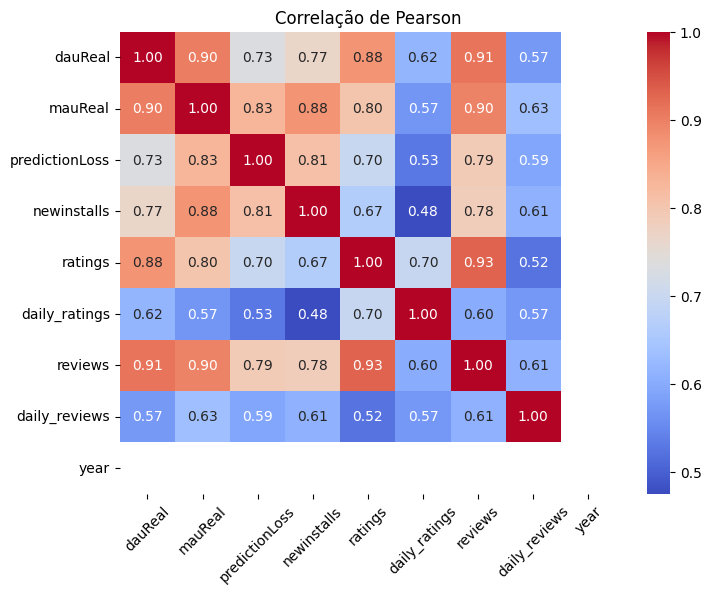

In [250]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45)
plt.title("Correlação de Pearson")
plt.show()

# 4.0 Carregamento dos Dados

Com os dados ordenados por data, separo 10% do conjunto para teste no notebook 3, e o restante fica para treino e validação.

In [251]:
df_completo = df_completo.sort_values(by=["appId", "date"])

In [252]:
train_val_size = 0.9
test_size = 0.1

n = len(df_completo)
train_val_end = int(train_val_size * n)

df_train_val = df_completo.iloc[:train_val_end]

df_test = df_completo.iloc[train_val_end:]

In [253]:
df_train_val.to_csv('../data/cleaned_data_for_modelling.csv', index=False)
df_test.to_csv('../data/test_data.csv', index=False)